In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

## Import network, extract data, and subset harbours

In [2]:
# import network
G = pickle.load(open('data/network_digital_twin_v0.3.pickle', 'rb'))


# extract position for drawing purposes
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'],G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# select berth nodes
berth_nodes = df_nodes.loc[df_nodes.n.str.contains('Berth')].index

# Step 1: review and clean original network

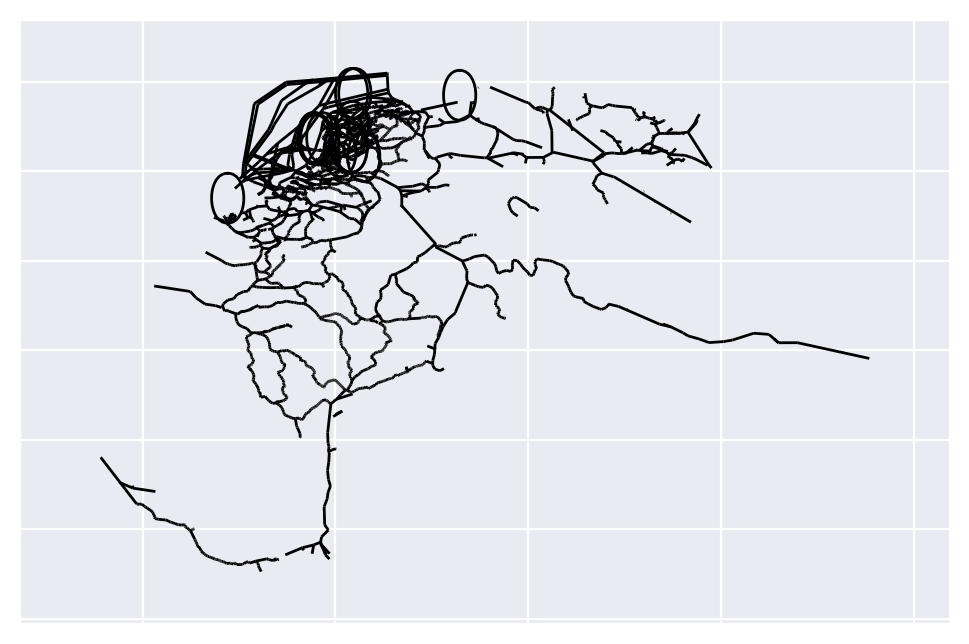

In [3]:
# visualize complete network
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos=pos_dict, width=1)

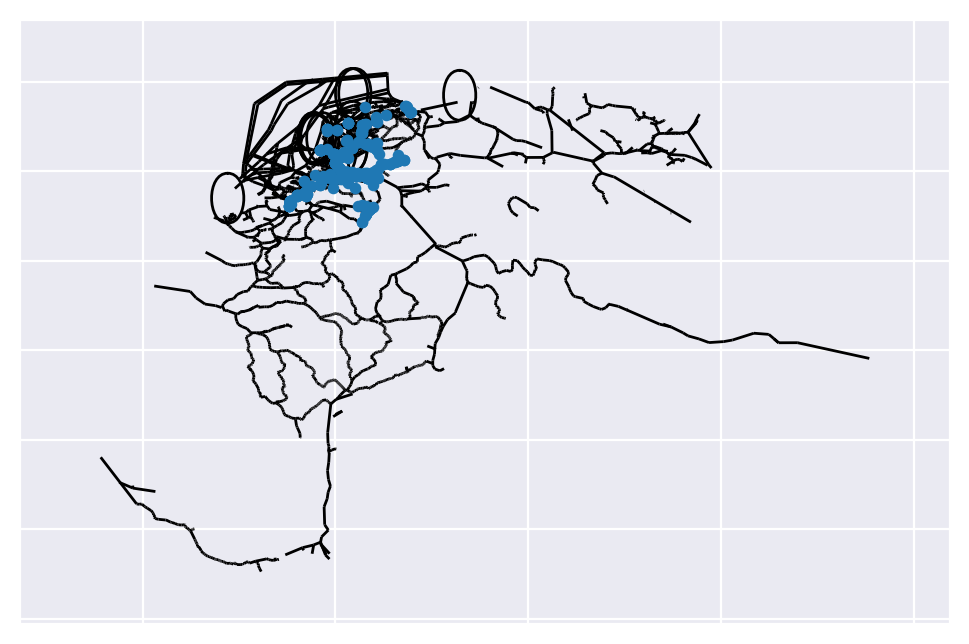

In [4]:
# now only plot the harbour nodes (with Berth in name)
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_nodes(G, pos_dict, berth_nodes, node_size=10)
nx.draw_networkx_edges(G, pos_dict, width = 1)
#good, harbour nodes appear to be quite strictly located in the netherlands

### Apply boundary box based on harbour nodes

## 1. Subset based on lat and lon harbours

In [5]:
# subset graph with harbours to be able to access X and Y for harbour nodes
df_nodes_harbours = df_nodes.loc[df_nodes.n.str.contains('Berth')]

In [6]:
#create boundary box
min_y = df_nodes_harbours.Y.min()
max_y = df_nodes_harbours.Y.max()
min_x = df_nodes_harbours.X.min()
max_x = df_nodes_harbours.X.max()

In [7]:
df_nodes = df_nodes.loc[(df_nodes.X.between(min_x, max_x)) & (df_nodes.Y.between(min_y, max_y))]

In [8]:
#visualise new subset

G = G.subgraph(df_nodes.index)

In [9]:
G = nx.Graph(G)

## Remove links from i to i

In [10]:
for node1, node2 in G.edges:
    if node1 == node2:
        print("Self loop identified node", node1)
        G.remove_edge(node1,node2)

Self loop identified node S46058_A
Self loop identified node S51275_A
Self loop identified node S16237927_A
Self loop identified node S48415_A
Self loop identified node S16240_A
Self loop identified node S24198_A
Self loop identified node S27425_A
Self loop identified node S28525_A
Self loop identified node S28525_B
Self loop identified node S56863_A
Self loop identified node S56863_B
Self loop identified node S57264_A


## Only keep nodes and edges that are on Dijkstra paths between Berth nodes

In [11]:
# node_list = []
# for origin_berth in berth_nodes:
#     a = list(berth_nodes)
#     a.remove(origin_berth)
#     for dest_berth in a:
#         try:
#             path = nx.dijkstra_path(G,origin_berth,dest_berth,'length_m')
#             node_list =  list(set(path) & set(node_list))
#         except:
#             print(f'no path from {origin_berth} to {dest_berth}')

In [12]:
# H = G.subgraph(berth_nodes)
# H = nx.Graph(H)

node_list = []
for node_1 in berth_nodes:
    a = df_nodes_harbours.loc[(df_nodes_harbours.X.between(df_nodes_harbours['X']-1, df_nodes_harbours['X']+1)) & (df_nodes_harbours.Y.between(df_nodes_harbours['Y']-1, df_nodes_harbours['Y']+1))&(df_nodes_harbours.index != node_1)]
    for node_2 in a.index:
            # determine route from a to b
        try:
            # get path
            path = nx.dijkstra_path(G, node_1, node_2, 'length_m')

            # add nodes to node list
            node_list.append(path)

            #remove duplicates
            node_list = list(set(node_list))

        except:
            print('no path between', node_1, node_2)

no path between Berth270 Berth0
no path between Berth270 Berth1
no path between Berth270 Berth2
no path between Berth270 Berth3
no path between Berth270 Berth4
no path between Berth270 Berth5
no path between Berth270 Berth6
no path between Berth270 Berth7
no path between Berth270 Berth8
no path between Berth270 Berth9
no path between Berth270 Berth10
no path between Berth270 Berth11
no path between Berth270 Berth12
no path between Berth270 Berth13
no path between Berth270 Berth14
no path between Berth270 Berth15
no path between Berth270 Berth16
no path between Berth270 Berth17
no path between Berth270 Berth18
no path between Berth270 Berth19
no path between Berth270 Berth20
no path between Berth270 Berth21
no path between Berth270 Berth22
no path between Berth270 Berth23
no path between Berth270 Berth24
no path between Berth270 Berth25
no path between Berth270 Berth26
no path between Berth270 Berth27
no path between Berth270 Berth28
no path between Berth270 Berth29
no path between Bert

In [17]:
df_nodes

n         X          Y  \
8867414    8867414  4.952974  52.376549   
8865307    8865307  4.954211  52.374431   
8864726    8864726  5.756117  52.573627   
8861055    8861055  5.757859  52.578609   
8861526    8861526  4.860551  52.396724   
...            ...       ...        ...   
Berth302  Berth302  5.222425  51.815990   
Berth303  Berth303  5.221081  51.815669   
8865499    8865499  5.219022  51.815177   
Berth305  Berth305  4.966948  51.827939   
22638307  22638307  4.967101  51.827933   

                                                   geometry  \
8867414   {'type': 'Point', 'coordinates': (4.9529743328...   
8865307   {'type': 'Point', 'coordinates': (4.9542113637...   
8864726   {'type': 'Point', 'coordinates': (5.7561165780...   
8861055   {'type': 'Point', 'coordinates': (5.7578594317...   
8861526   {'type': 'Point', 'coordinates': (4.8605511761...   
...                                                     ...   
Berth302  {'type': 'Point', 'coordinates': (5.2224246051...   
Berth303  {'type': 'Point', 'coordinates': (5.2210806772...   
8865499   {'type': 'Point', 'coordinates': (5.2190220131...   
Berth305  {'type': 'Point', 'coordinates': (4.9669477560...   
22638307  {'type': 'Point', 'coordinates': (4.9671009281...   

                                                     Wkt  
8867414   POINT (4.9529743328171900 52.3765489377136007)  
8865307   POINT (4.9542113637339202 52.3744310413327980)  
8864726   POINT (5.7561165780084798 52.5736268471534984)  
8861055   POINT (5.7578594317824701 52.5786094645163971)  
8861526   POINT (4.8605511761302900 52.3967238141143028)  
...                                                  ...  
Berth302  POINT (5.2224246051149352 51.8159898381213324)  
Berth303  POINT (5.2210806772796499 51.8156686832568596)  
8865499   POINT (5.2190220131971898 51.8151767297702008)  
Berth305  POINT (4.9669477560782163 51.8279388662828069)  
22638307  POINT (4.9671009281155802 51.8279326726516985)  

[10034 rows x 5 columns]

In [26]:
expanded_node_list = [x for xs in node_list for x in xs]

In [28]:
node_list = list(set(expanded_node_list))

In [30]:
G = G.subgraph(node_list)

In [31]:
G = nx.Graph(G)

## Visualize resulting network

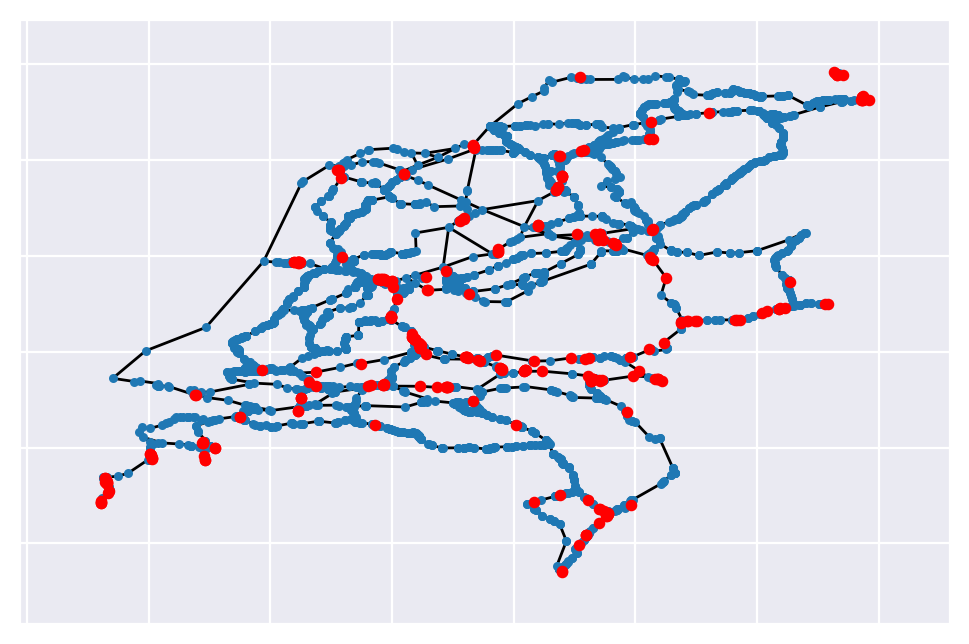

In [40]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, node_size=5)
nx.draw_networkx_nodes(G, pos_dict, berth_nodes, node_size=10, node_color='red')

## Worked!!

However, there are clearly some islands. Q: how many harbour nodes are not connected to the network now?
Should they be connected manually? Otherwise, they should be deleted.

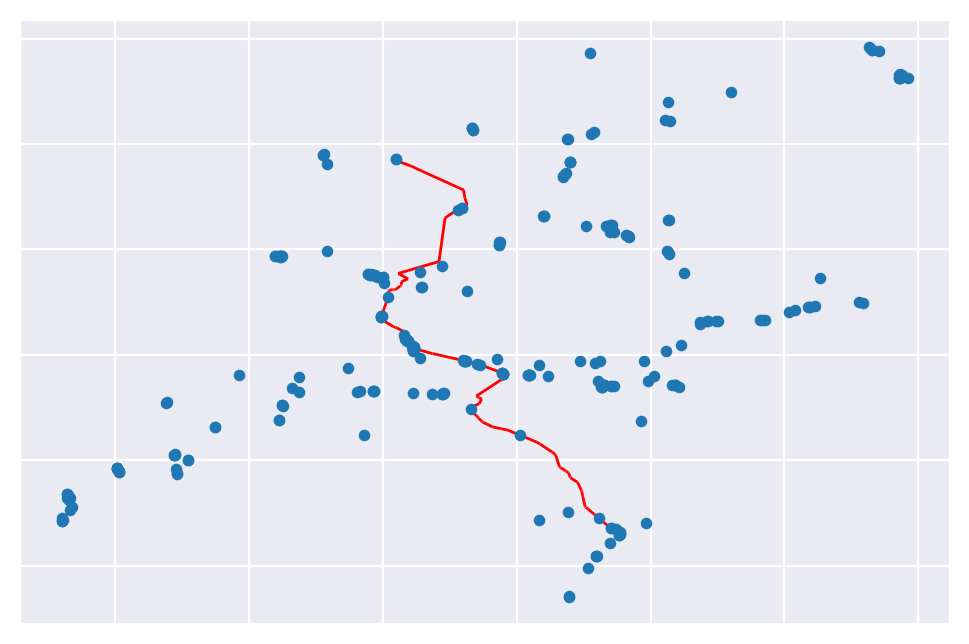

In [38]:
fig, ax = plt.subplots(dpi=200)
route1=nx.dijkstra_path(G,"Berth197", 'Berth10', weight='length_m')

edges_route_1 = []
for i in range(len(route1)-1):
    edges_route_1.append((route1[i],route1[i+1]))

# nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, berth_nodes, node_size=10)
nx.draw_networkx_edges(G,pos_dict,edges_route_1, edge_color='red')

In [23]:
#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [ ]:
H = G.subgraph(berth_nodes)
H = nx.Graph(H)
for node_1 in H:
    a = df_nodes.loc[(df_nodes.X.between(df_nodes['X']-0.5, df_nodes['X']+0.5)) & (df_nodes.Y.between(df_nodes['Y']-0.5, df_nodes['Y']+0.5))]
    for node_2 in a.index:
        if (node_1 != node_2) and (node_2 in berth_nodes):
            # determine route from a to b
            try:
                a = nx.shortest_path(G, node_1, node_2)
                a = a[1:]
                a = a[:-1]
                b = list(set(a) & set(berth_nodes))
                if not b:
                    if not ((node_1,node_2) in H.edges) or ((node_2,node_1) in H.edges):
                        c = nx.dijkstra_path_length(G,node_1, node_2, 'length_m')
                        H.add_edge(node_1, node_2, length_m=c)
            except:
                print('no path between', node_1, node_2)

no path between Berth34 Berth38
no path between Berth34 Berth39
no path between Berth34 Berth196
no path between Berth34 Berth279
no path between Berth34 Berth280
no path between Berth207 Berth38
no path between Berth207 Berth39
no path between Berth207 Berth196
no path between Berth207 Berth279
no path between Berth207 Berth280
no path between Berth30 Berth38
no path between Berth30 Berth39
no path between Berth30 Berth196
no path between Berth30 Berth279
no path between Berth30 Berth280
no path between Berth183 Berth38
no path between Berth183 Berth39
no path between Berth183 Berth196
no path between Berth183 Berth279
no path between Berth183 Berth280
no path between Berth270 Berth38
no path between Berth270 Berth39
no path between Berth270 Berth196
no path between Berth270 Berth279
no path between Berth270 Berth280
no path between Berth112 Berth38
no path between Berth112 Berth39
no path between Berth112 Berth196
no path between Berth112 Berth279
no path between Berth112 Berth280
no

In [15]:
# from networkx.algorithms.dag import transitive_closure
#
# def dependency_graph(G, nodes):
#     return transitive_closure(G).subgraph(nodes)
#
# edges = dependency_graph(G, [berth_nodes]).edges

KeyboardInterrupt: 

### Failed try: Remove links based on attribute values, only keep remaining source and target nodes

In [11]:
df_links.Code.unique()

array([nan, 'VI_B', 'V_A', 'II', '_0', 'III', 'VI_C', 'V_B', 'VI_A', 'IV',
       'I'], dtype=object)

In [12]:
#remove recreatievaart
df_2 = df_links.loc[df_links.Code != '_0']

In [13]:
# subset graph
orgs = df_2.source.unique()
dests = df_2.target.unique()
to_keep = list(set(orgs) & set(dests))

H = G.subgraph(to_keep)

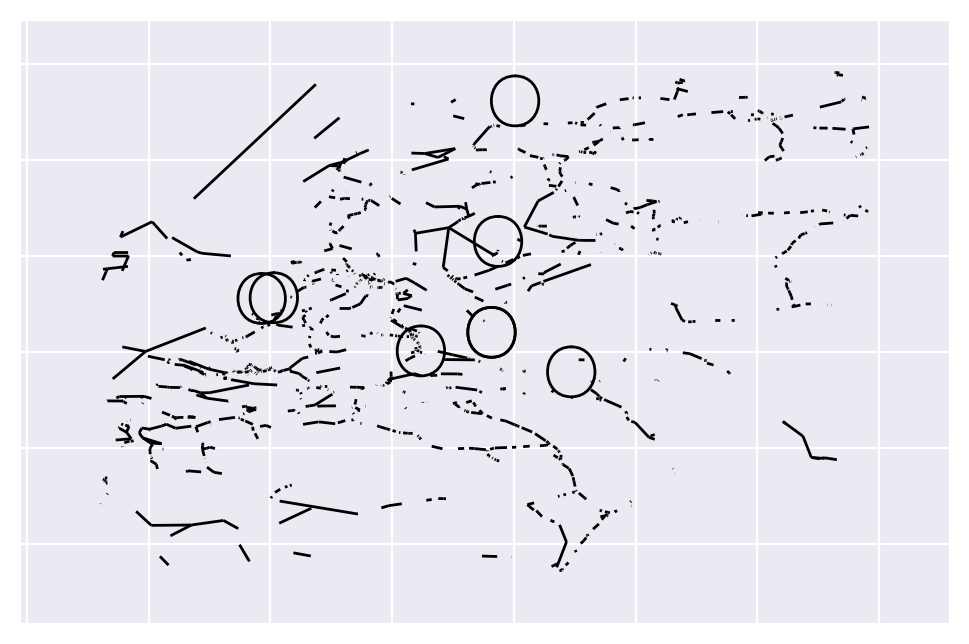

In [14]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(H, pos_dict)

## Clustering
https://www.learndatasci.com/tutorials/k-means-clustering-algorithms-python-intro/

### Step 1: make edge matrix with a row and column for each entry, which entry is 1 if an edge exists and 0 otherwise

In [42]:
def graph_to_edge_matrix(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/Incidence_matrix for a good explanation on edge matrices

    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    graph_dict = dict()
    graph_dict['nodes'] = G.nodes
    for node in G.nodes:
        graph_dict[node] = []

    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node_1 in graph_dict['nodes']:
        for node_2 in graph_dict['nodes']:
            if (node_2 in G.neighbors(node_1)) or (node_1 == node_2):
                graph_dict[node_1].append(1)
            else:
                graph_dict[node_1].append(0)

    return graph_dict

In [43]:
# df = graph_to_edge_matrix(G)
# df = pd.DataFrame.from_dict(df)
# df.set_index('nodes', inplace=True)
# pickle.dump(df, open( "data/edge_matrix.p", "wb" ) )

### Step 2

In [44]:
edge_mat = df_matrix.to_numpy()

In [45]:
edge_mat

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

In [46]:
k_clusters = 1400
results = []
algorithms = {}

algorithms['kmeans'] = cluster.KMeans(n_clusters=k_clusters, n_init=1)

In [47]:
for model in algorithms.values():
    model.fit(edge_mat)
    results.append(list(model.labels_))

In [51]:
results[0]

[17,
 17,
 4,
 4,
 1304,
 1304,
 1295,
 4,
 1365,
 1365,
 1053,
 463,
 526,
 526,
 528,
 528,
 948,
 948,
 873,
 4,
 4,
 4,
 159,
 159,
 1090,
 4,
 4,
 4,
 561,
 561,
 40,
 40,
 4,
 704,
 299,
 299,
 97,
 97,
 1053,
 4,
 289,
 289,
 4,
 4,
 510,
 510,
 4,
 4,
 568,
 568,
 211,
 211,
 4,
 4,
 115,
 115,
 212,
 212,
 660,
 660,
 1013,
 4,
 515,
 515,
 211,
 253,
 4,
 4,
 85,
 4,
 91,
 4,
 606,
 606,
 825,
 825,
 750,
 4,
 563,
 563,
 4,
 4,
 4,
 4,
 1104,
 510,
 510,
 4,
 4,
 159,
 1201,
 28,
 4,
 4,
 301,
 301,
 695,
 4,
 4,
 4,
 1,
 1,
 1333,
 1333,
 4,
 4,
 481,
 481,
 158,
 4,
 4,
 4,
 4,
 234,
 4,
 4,
 192,
 192,
 1195,
 1195,
 531,
 4,
 4,
 137,
 4,
 4,
 4,
 4,
 1140,
 1140,
 1050,
 4,
 4,
 4,
 143,
 143,
 132,
 132,
 4,
 4,
 112,
 112,
 851,
 4,
 4,
 4,
 374,
 374,
 695,
 695,
 414,
 414,
 286,
 1055,
 522,
 4,
 4,
 4,
 1246,
 4,
 27,
 27,
 4,
 4,
 730,
 730,
 4,
 4,
 4,
 4,
 303,
 303,
 1240,
 4,
 561,
 4,
 4,
 4,
 503,
 503,
 4,
 4,
 963,
 4,
 52,
 4,
 463,
 463,
 281,
 281,
 86

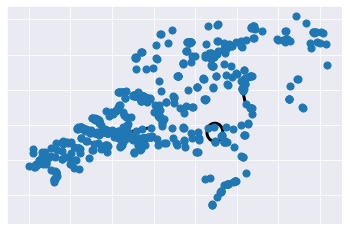

In [12]:
H = G.subgraph(harbour_exits)
nx.draw_networkx(H, pos_dict, with_labels=False, node_size=50, width=3)

In [13]:
H = nx.Graph(H)
for node_1 in H:
    print(node_1)
    for node_2 in H:
        if node_1 != node_2:
            # determine route from a to b
            a = nx.shortest_path(G, node_1, node_2)
            a = a[1:]
            a = a[:-1]
            b = list(set(a) & set(harbour_exits))
            if not b:
                if not ((node_1,node_2) in H.edges) or ((node_2,node_1) in H.edges):
                    c = nx.dijkstra_path_length(G,node_1, node_2, 'length_m')
                    H.add_edge(node_1, node_2, length_m=c)


8868207
8868177
8868404
8862506
8864260
8865186
8861602
8862034
8863773
8860657
8868359
8864197
8862386
8864161
8866477
8868393
8867264
8863006
8864482
8867060
8866736
8861330
8860614
8866763
8866045
8868011
8868191
8865276
8864082
8862133
8864181
8863295
8868294
8867702
8863471
8865175
8867030
21467614
8867160
8866899
8867601
8864108
8863603
8863311
8863216
8867795
8866780
8865894
8861553
10488638
8860942
8863124
8866601
8867089
8863700
8860675
8867893
8861097
26519895
8865818
8861785
8860833
8867928
8867574
8867516
8862228
8865967
8862989
8866573
8866425
8865405
8865993
8868151
8860870
8864349
8864798
8862340
8862597
8864685
8867986
8862687
8865010
8863261
8864467
8866661
8866129
8863252
8863599
8862507
8862883
8866520
8862031
8867731
8865183
28313910
8866901
8862721
8867510
8864682
22161377
8867489
8862925
8866775
8866566
8863264
8865003
8862930
8860580
8861292
8866183
8864435
8867374
8866694
8868307
8864684
8862336
8864288
8867855
8861738
8865550
8863979
8868275
19440565
8866512
88

In [14]:
# pickle.dump(H, open( "data/cleaned_graph.p", "wb" ) )

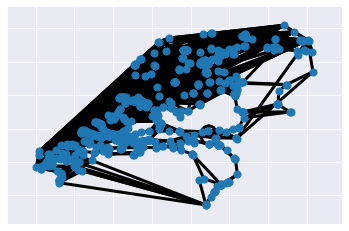

In [15]:
# nx.draw_networkx(H, pos_dict, with_labels=False, node_size=50, width=3)

In [ ]:
#Hasn't worked too wel...
#Maybe try it again with smaller network first, iteratively simplify?

## New try k-means application

In [5]:
#draw harbour nodes and set bounding box based on these nodes

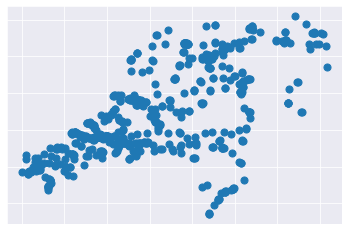

In [48]:
# now only plot the harbour nodes
nx.draw_networkx_nodes(G, pos_dict,harbour_exits, node_size=50)

In [49]:
# subset graph
H = G.subgraph(harbour_exits)

In [50]:
#get data
df_links_harbours = nx.to_pandas_edgelist(H)
df_nodes_harbours = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')

In [51]:
# now get max X and Y
min_y = df_nodes_harbours.Y.min()
max_y = df_nodes_harbours.Y.max()
min_x = df_nodes_harbours.X.min()
max_x = df_nodes_harbours.X.max()
# min_x, min_y, max_x, max_y = 3.31497114423, 50.803721015, 7.09205325687, 53.5104033474

In [52]:
## now get data from whole network, and subset based on x and y
#Get data from df
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [53]:
min_x

3.5061616660564403

In [54]:
df_subset = df_nodes.loc[(df_nodes.X.between(min_x, max_x)) & (df_nodes.Y.between(min_y, max_y))]

In [55]:
df_subset.describe()

X            Y
count  9427.000000  9427.000000
mean      5.346622    52.379267
std       0.840929     0.617289
min       3.506162    50.856549
25%       4.754417    51.907909
50%       5.228611    52.369581
75%       5.951426    52.949961
max       7.081601    53.546220

In [56]:
H2 = G.subgraph(df_subset.index)

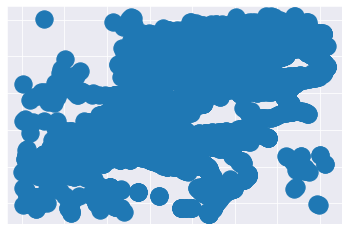

In [57]:
nx.draw_networkx_nodes(H2, pos=pos_dict)

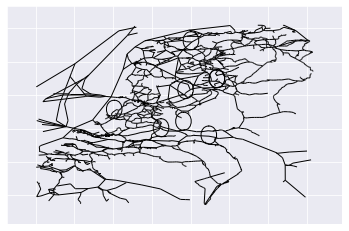

In [58]:
nx.draw_networkx_edges(H2, pos=pos_dict)

In [139]:
df_subset.loc[df_subset.X > 7.08]

X          Y  \
B15200_A  7.081007  52.862374   
B15200_B  7.081012  52.862274   
B16780_A  7.081494  52.854246   
B16780_B  7.081500  52.854146   
8863077   7.081601  52.851295   
L37289_A  7.080949  52.863189   
L37289_B  7.080978  52.862790   

                                                   geometry  \
B15200_A  {'type': 'Point', 'coordinates': (7.0810069385...   
B15200_B  {'type': 'Point', 'coordinates': (7.0810119079...   
B16780_A  {'type': 'Point', 'coordinates': (7.0814938536...   
B16780_B  {'type': 'Point', 'coordinates': (7.0815000229...   
8863077   {'type': 'Point', 'coordinates': (7.0816013838...   
L37289_A  {'type': 'Point', 'coordinates': (7.0809491830...   
L37289_B  {'type': 'Point', 'coordinates': (7.0809779476...   

                                                     Wkt  
B15200_A  POINT (7.0810069385504599 52.8623737378234040)  
B15200_B  POINT (7.0810119079780094 52.8622738613757832)  
B16780_A  POINT (7.0814938536027983 52.8542457679538842)  
B16780_B  POINT (7.0815000229184131 52.8541459584375772)  
8863077   POINT (7.0816013838218304 52.8512948968008729)  
L37289_A  POINT (7.0809491830156306 52.8631894471106989)  
L37289_B  POINT (7.0809779476333636 52.8627904827053072)

## Compute vessel sum per route

In [ ]:
# now subset main routes before clustering
# based on x most completed trips?
# step 1: compute most completed trips and link to nodes

In [63]:
df_2021 = pd.read_csv('data/2021/2021_combined.csv')
all_trips_ranked=df_2021.groupby(by=['UNLO_herkomst','UNLO_bestemming']).count().reset_index().sort_values(by='Jaarmaand',ascending=False).iloc[:,:3].reset_index(drop=True)

In [127]:
# make dict to store trips
trip_dict = {}

# now fill this dict
for i in range(len(all_trips_ranked)-1):
    origin = all_trips_ranked['UNLO_herkomst'][i]
    destination = all_trips_ranked['UNLO_bestemming'][i]
    trip_count = all_trips_ranked['Unnamed: 0'][i]

    if (origin, destination) in trip_dict.keys():
        trip_dict[(origin, destination)] += trip_count
    elif (destination, origin) in trip_dict.keys():
        trip_dict[(destination, origin)] += trip_count
    else:
        trip_dict[(origin, destination)] = trip_count





In [129]:
# now sort values
trip_dict = dict(sorted(trip_dict.items(), key=lambda item: item[1], reverse= True))

In [135]:
trip_dict_df = {'origin': [], 'destination': [], 'trip_count': []}
for key, value in trip_dict.items():
    trip_dict_df['origin'].append(key[0])
    trip_dict_df['destination'].append(key[1])
    trip_dict_df['trip_count'].append(value)

In [137]:
pd.DataFrame.from_dict(trip_dict_df)

origin destination  trip_count
0      BEANR       NLRTM       18754
1      NLRTM       NLAMS        9960
2      BEANR       BEGNE        5465
3      BEANR       NLAMS        3891
4      DESGW       NLRTM        3252
...      ...         ...         ...
25514  NLBZM       NLVER           1
25515  NLBZM       NLSMB           1
25516  NLBZM       NLSHH           1
25517  NLBZM       NLROZ           1
25518  NLBZM       NLRAA           1

[25519 rows x 3 columns]

In [ ]:
# lots of destinations

In [132]:
pd.DataFrame.from_dict(trip_dict, index=trip_dict.keys())

TypeError: DataFrame.from_dict() got an unexpected keyword argument 'index'

## Now get coordinates harbours

In [87]:
pd.read_csv('data/harbour_codes_coords/2021-2 UNLOCODE CodeListPart1.csv',encoding = "ISO-8859-1", header = None, sep=",", index_col=None)

0   1    2                   3                   4    5         6   \
0      NaN  AD  NaN            .ANDORRA                 NaN  NaN       NaN   
1      NaN  AD  ALV    Andorra la Vella    Andorra la Vella  NaN  --34-6--   
2      NaN  AD  CAN             Canillo             Canillo  NaN  --3-----   
3      NaN  AD  ENC              Encamp              Encamp  NaN  --3-----   
4      NaN  AD  ESC  Escaldes-Engordany  Escaldes-Engordany  NaN  --3-----   
...    ...  ..  ...                 ...                 ...  ...       ...   
54611  NaN  FR  ZTG             Zetting             Zetting   57  --3-----   
54612  NaN  FR  ZL2               Zilia               Zilia   2B  -----6--   
54613  NaN  FR  ZWL          Zinswiller          Zinswiller   67  --3-----   
54614  NaN  FR  PCZ              Zoteux              Zoteux   62  -----6--   
54615  NaN  FR  559           Zuytpeene           Zuytpeene   59  --3-----   

        7       8    9             10   11  
0      NaN     NaN  NaN           NaN  NaN  
1       AI   601.0  NaN  4230N 00131E  NaN  
2       RL   307.0  NaN  4234N 00135E  NaN  
3       RL   307.0  NaN  4232N 00134E  NaN  
4       RL   307.0  NaN  4231N 00133E  NaN  
...    ...     ...  ...           ...  ...  
54611   RL  1901.0  NaN  4905N 00708E  NaN  
54612   RL  1901.0  NaN  4231N 00854E  NaN  
54613   RL  1901.0  NaN  4855N 00735E  NaN  
54614   RL  1001.0  NaN  5037N 00153E  NaN  
54615   RL  1607.0  NaN  5048N 00226E  NaN  

[54616 rows x 12 columns]

In [89]:
#first identify all files in 2021 folder and save their names
from os import walk
f = []
for (dirpath, dirnames, filenames) in walk('data/harbour_codes_coords'):
    f.extend(filenames)
    break

In [91]:
#empty list to store data
li=[]

#read everything in as object for now
for filename in f:
    df = pd.read_csv("data/harbour_codes_coords/"+str(filename), sep=',', index_col=None, header=None, encoding = "ISO-8859-1")
    print(filename,'handled')
    li.append(df)

#create df
df_harbour_codes = pd.concat(li, axis=0, ignore_index=True)

2021-2 UNLOCODE CodeListPart1.csv handled
2021-2 UNLOCODE CodeListPart2.csv handled
2021-2 UNLOCODE CodeListPart3.csv handled


In [107]:
df_benelux = df_harbour_codes.loc[(df_harbour_codes[1]=='NL')|(df_harbour_codes[1]=='DE')|(df_harbour_codes[1] == 'BE')|(df_harbour_codes[1] == 'LU')]

In [126]:
# now drop empty columns
df_benelux.rename(columns={0:'mutation', 1:'country', 2:'city_abbr', 3:'City_full', 4:'City_full_2',})

type   1    2            3            4    5         6    7       8  \
5129   NaN  BE  NaN     .BELGIUM          NaN  NaN       NaN  NaN     NaN   
5130   NaN  BE  ALB      Aalbeke      Aalbeke  VWV  -----6--   RL   601.0   
5131   NaN  BE  AAB        Aalst        Aalst  VOV  1-3-----   RN   307.0   
5132   NaN  BE  AAL       Aalter       Aalter  VOV  1-3-----   RN   307.0   
5133   NaN  BE  AAS     Aarschot     Aarschot  VBR  --3-----   RN   307.0   
...    ...  ..  ...          ...          ...  ...       ...  ...     ...   
80512  NaN  NL  ZWS   Zwartsluis   Zwartsluis  NaN  1-3-----   RL  9811.0   
80513  NaN  NL  ZGE    Zwiggelte    Zwiggelte   DR  --3-----   RL   407.0   
80514  NaN  NL  ZWI  Zwijndrecht  Zwijndrecht  NaN  123-----   AF  9602.0   
80515  NaN  NL  ZWN    Zwinderen    Zwinderen   DR  1-3-----   RN   501.0   
80516  NaN  NL  ZWO       Zwolle       Zwolle  NaN  -23-----   AF  9602.0   

         9            10   11  
5129   NaN           NaN  NaN  
5130   NaN  5046N 00313E  NaN  
5131   NaN  5056N 00402E  NaN  
5132   NaN  5105N 00327E  NaN  
5133   NaN  5059N 00450E  NaN  
...    ...           ...  ...  
80512  NaN           NaN  NaN  
80513  NaN  5252N 00635E  NaN  
80514  NaN           NaN  NaN  
80515  NaN  5244N 00641E  NaN  
80516  NaN           NaN  NaN  

[13862 rows x 12 columns]

In [121]:
df_benelux[0].unique()

array([nan, '=', '+', '¦'], dtype=object)